## xcube Data Store Framework – Climate Data Store

This notebook demonstrates how to access [Climate Data Store](https://cds.climate.copernicus.eu) (CDS) data via the dedicated xcube store, which provides dynamic data cube views into each gridded data set.

Please, also refer to the [DeepESDL documentation](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/) and visit the platform's [website](https://www.earthsystemdatalab.net/) for further information!

Brockmann Consult, 2024

-----------------

**This notebook runs with the python environment `deepesdl-xcube-1.7.0`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**

**Please note:** 
    
To access data from the Climate Data Store, you need a CDS API key. 

#### Obtain a CDS Personal Access Token

You can obtain a CDS Personal Access Token as follows:

1. Create a user account on the
   [CDS Website](https://cds-beta.climate.copernicus.eu/).
2. Log in to the website with your username and password.
3. Navigate to your [user page](https://cds-beta.climate.copernicus.eu/profile), 
   where you can find your Personal Access Token.

#### Configure CDS API access

Your CDS Personal Access Token must be made available to the CDS API library.
You can do this by creating a file named `.cdsapirc` in your home directory,
with the following format:

```
url: https://cds-beta.climate.copernicus.eu/api
key: <PERSONAL-ACCESS-TOKEN>
```

Replace `<PERSONAL-ACCESS-TOKEN>` with your Personal Access Token.

Then export the `CDSAPI_URL` and `CDSAPI_KEY` environment variables:

```bash
export CDSAPI_URL=https://cds-beta.climate.copernicus.eu/api
export CDSAPI_KEY=[PERSONAL-ACCESS-TOKEN]
```

#### Agree to the terms of use for the datasets you require

The datasets available through CDS have associated terms of use. Before
accessing a dataset via the API, you must agree to its terms of use, which
can only be done via the CDS website, as follows:

1. [Log in](https://cds-beta.climate.copernicus.eu) to the CDS website,
   and go to 'Datasets' to find the dataset you require.
2. On the dataset's web page, select the ‘Download’ tab.
3. Scroll to the bottom of the page, and you will see a section titled
   ‘Terms of use’, which will contain either an ‘Accept terms’ button to
   allow you to accept the terms, or a confirmation that you have already
   accepted the terms.

Once you have accepted the terms on the website, the dataset will also be
made available to you through the API.

In [17]:
import os
os.environ['CDSAPI_URL'] = 'https://cds-beta.climate.copernicus.eu/api'
os.environ['CDSAPI_KEY'] = '[PERSONAL-ACCESS-TOKEN]'

In [2]:
# mandatory imports
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store

# Utilities for notebook visualization
from IPython.display import JSON
import matplotlib as mpl
import matplotlib.pyplot as plt

Configure matplotlib to display graphs inline directly in the notebook and set a sensible default figure size.

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 16,12

Check whether the `cds` store is among the available stores, if not please follow the installation information from the top of this notebook. 

In [4]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

Usually we need more information to get the actual data store object. Which data store parameters are available for `cds`?

In [5]:
get_data_store_params_schema('cds')

Provide mandatory parameters to instantiate the store class:

In [6]:
store = new_data_store('cds')
store

Which datasets are provided? (the list may contain both gridded and vector datasets):

In [7]:
JSON(store.list_data_ids())

<IPython.core.display.JSON object>

Get more info about a specific dataset. This includes a description of the possible open formats:

In [8]:
store.describe_data('reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis')

There are 4 required parameters, so we need to provide them to open a dataset:

In [14]:
dataset = store.open_data('reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis', 
                          variable_names=['2m_temperature'], 
                          bbox=[-10, 45, 40, 65], 
                          spatial_res=0.25, 
                          time_range=['2006-01-01', '2010-12-31'])
dataset

xcube-cds version 0.9.3
2024-09-18 08:02:01,436 INFO Request ID is 2cf61c9d-916c-4ff4-93a5-5a46c901fa55
2024-09-18 08:02:01,478 INFO status has been updated to accepted
2024-09-18 08:02:05,317 INFO status has been updated to running
2024-09-18 08:02:08,727 INFO Creating download object as as_source with files:
['data_0.nc']
2024-09-18 08:02:13,829 INFO status has been updated to successful


1053781ec8bc0f7cd4903487de286a77.nc:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

<xarray.Dataset> Size: 4MB
Dimensions:  (lat: 80, lon: 200, time: 60)
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 640B 64.88 64.62 64.38 64.12 ... 45.62 45.38 45.12
  * lon      (lon) float64 2kB -9.875 -9.625 -9.375 -9.125 ... 39.38 39.62 39.88
    expver   (time) <U4 960B ...
  * time     (time) datetime64[ns] 480B 2006-01-01 2006-02-01 ... 2010-12-01
Data variables:
    t2m      (time, lat, lon) float32 4MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-18T08:02 GRIB to CDM+CF via cfgrib-0.9.1...

Plot the differences between successive time points in the dataset. We can see that the times are monotonically increasing (all the difference values are positive), but not equally spaced, since months are not all of the same length. The lowest values correspond to February; the four-year leap year cycle can also be discerned.

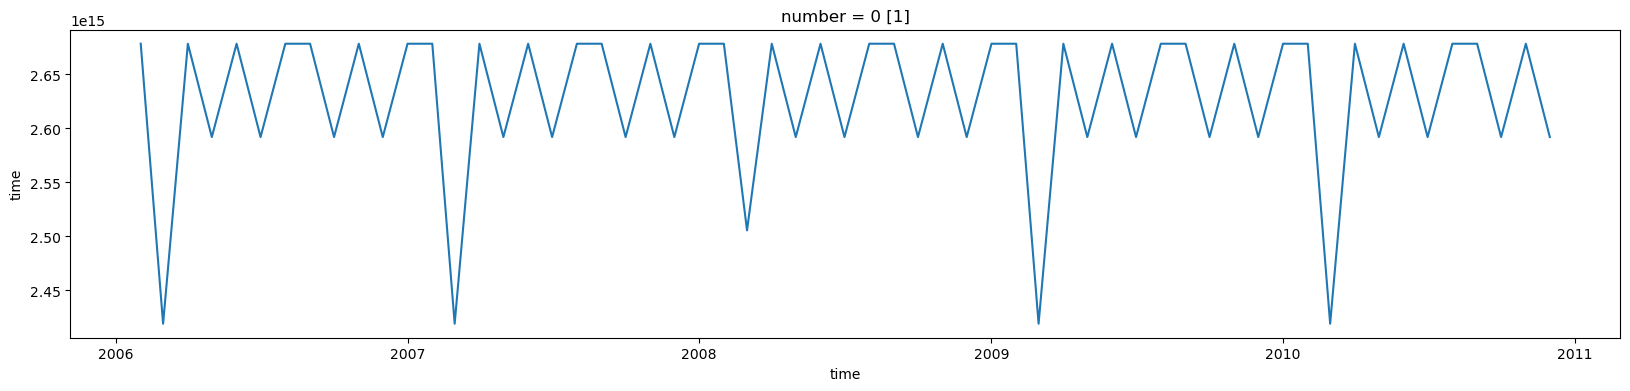

In [15]:
dataset.time.diff(dim='time').plot.line(figsize=(20, 4))

We can explore these data by plotting a temperature map for selected time points. First, we select January 2001. Land areas – and mountain ranges in particular – show up on the map as colder regions.

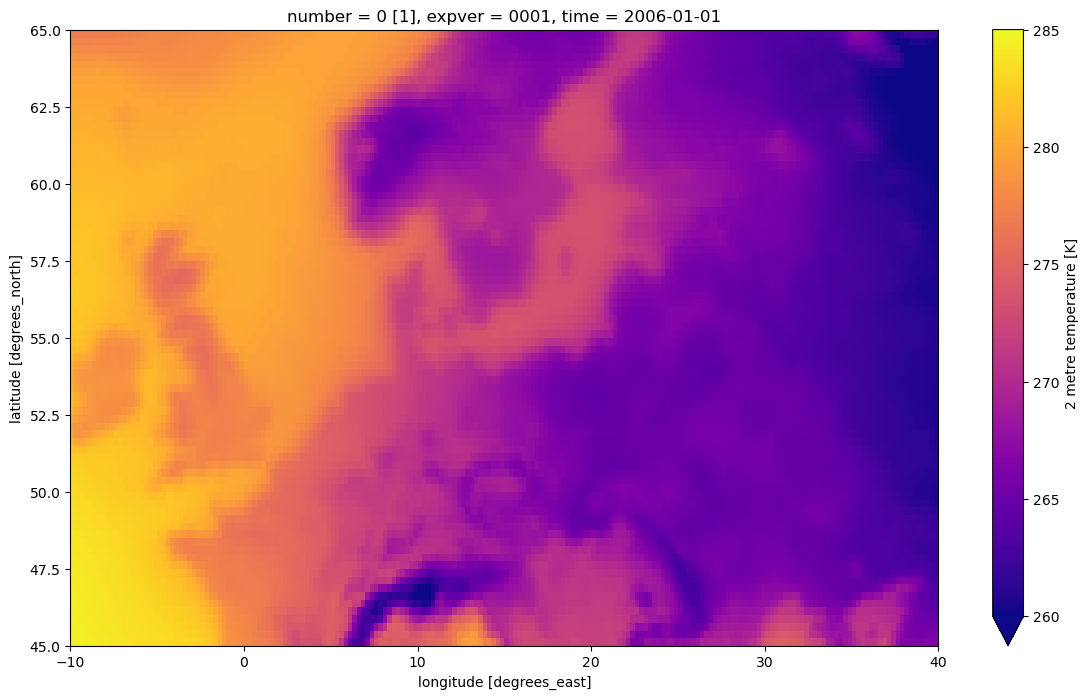

In [16]:
t2m_2001_jan = dataset.t2m.sel(time='2001-01-01 00:00:00', method='nearest')
t2m_2001_jan.plot.imshow(vmin=260, vmax=285, figsize=(14, 8), cmap='plasma')

For a more elegant and informative map, we define a function to plot a customized orthographic projection with overlaid coastlines and a grid.
